In [29]:
import pandas as pd 
import numpy as np
import os
from PIL import Image
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from sklearn.model_selection import train_test_split
import pickle
import ast 
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("ltp_df.csv")

image_files = df['image']
N = len(df) #2802
sample_img = Image.open("../data/combined/" + image_files[0]).convert('RGB')
img_array = np.asarray(sample_img, dtype=np.float32) / 255.0
flattened_size = img_array.size
print(N,flattened_size)
#flattened size = 1024*512*3
images_array = np.zeros((N, flattened_size), dtype=np.float32)

for i, file in enumerate(image_files):
    img = Image.open("../data/combined/" + file).convert('RGB')
    img_array = np.asarray(img, dtype=np.float32) / 255.0
    images_array[i, :] = img_array.flatten()

2802 1572864


In [3]:
X = images_array 
y = torch.tensor([ ast.literal_eval(t) for t in df['target'] ])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


/tmp/ipykernel_1443965/1287277756.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
/tmp/ipykernel_1443965/1287277756.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_tensor = torch.tensor(y_test, dtype=torch.long)


# MLP

In [43]:
class MLP(nn.Module): 
    def __init__(self, input_size): 
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 128) 
        self.relu = nn.ReLU() 
        self.fc2 = nn.Linear(128, 8) # 8 is number of classes 
    def forward(self,x): 
        x = self.fc1(x)
        x = self.relu(x)
        latent = x 
        x = self.fc2(x) 
        return x, latent #raw logits 
    

In [44]:
model = MLP(input_size=1024*512*3)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [45]:

# Training loop
for epoch in range(5):  # Adjust number of epochs
    model.train()  # Set model to training mode
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        outputs, _ = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")


Epoch 1, Loss: 12.91780831416448
Epoch 2, Loss: 2.2721940212779574
Epoch 3, Loss: 2.212660249736574
Epoch 4, Loss: 1.5629470116562314
Epoch 5, Loss: 1.6891115175353155


In [46]:
# Testing loop
model.eval()  # Set model to evaluation mode
correct = 0
total = 0
latent_representations = []
labels_list = []

with torch.no_grad():  # No need to track gradients during testing
    for inputs, labels in test_loader:
        outputs, latent = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        labels = torch.argmax(labels, dim=1)  # Convert one-hot labels to class indices
        latent_representations.append(latent.cpu().numpy())  # Store the latent representation (convert to numpy)
        labels_list.append(labels.cpu().numpy())
        total += labels.size(0)  # Increment the total number of samples
        correct += (predicted == labels).sum().item()  # Count correct predictions

# Calculate accuracy
accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")  # Print accuracy as a percentage


Test Accuracy: 50.80%


In [47]:
latent_representations = np.vstack(latent_representations)  # Combine the latent representations into one array
labels_list = np.concatenate(labels_list) 
pca = PCA(n_components=2)  # Reduce to 2D for visualization
latent_pca = pca.fit_transform(latent_representations)  # Apply PCA to the latent representations

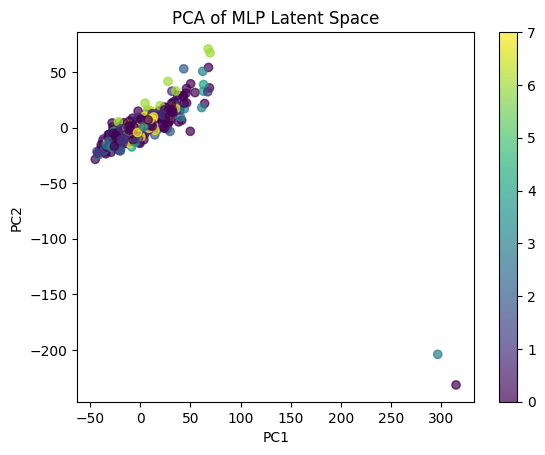

In [48]:


# Visualize the results
plt.scatter(latent_pca[:, 0], latent_pca[:, 1], c=labels_list, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title("PCA of MLP Latent Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# AutoEncoder 

In [52]:
class AutoEncoder(nn.Module): 
    
    def __init__(self, input_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128), 
            nn.ReLU(), 
        )
        self.decoder = nn.Sequential(
            nn.Linear(128, input_dim), 
            nn.Sigmoid()
        )
    def forward(self, x): 
        x = self.encoder(x)
        x = self.decoder(x) 
        
        

In [54]:
model = AutoEncoder(1024*512*3)
criterion = nn.MSELoss()  #mse
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [55]:

# Training loop
for epoch in range(5):  # Adjust number of epochs
    autoencoder.train()  # Set model to training mode
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")


AttributeError: 'NoneType' object has no attribute 'size'